# Module 4 - Reducing unfairness in learning algorithm applications 


### Assignment overview

In this assignment, you are tasked to create a classifer to predict the estimated income of individuals in the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). This dataset is known to be biased towards certain groups. You will try some strategies to create a more fair classifier.

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Xueyong Zhang
- Student 2: Yuwen Luo


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Discuss the consequences of erroneous (biased) data on the training of learning algorithms and how it impacts its end users  
2. Discuss potential ethical implications in errors in feature selection, model selection 
3. Describe strategies for reducing algorithmic bias 
4. Apply strategies to reduce unfairness in a predictive model trained on an unbalanced dataset 
5. Describe advantages and limitations of the strategies used to reduce unfairness in predictive models

### Libraries

Here are some libraries you will need for this assignment. `imblearn` and `aif360` are new ones, you can install it by running the cell below. Comment out this line after one execution:

In [51]:
# !pip install imblearn
# !pip install aif360

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.datasets import BinaryLabelDataset

import warnings
warnings.filterwarnings('ignore')

### Dataset

The dataset you will use for this assignment is the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). You may visit the source page for more information about this dataset.

The dataset includes 15 columns: 14 of them are demographics and other features to describe a person, and one (the target variable), is their income. The income variable is binary and has the two possible values `<=50K` or `>50K`.

Let's start by importing the dataset and taking a look (you are free to add other lines if you want more details):

In [53]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Unfortunately, this dataset is notoriously biased in the association between income and other demographic information, such as race and gender. Let's see how.

#### Question 1 
Create the following 3 bar charts:
- A global bar chart of the target variable
- A bar chart of the target variable divided by gender
- A bar chart of the target variable divided by race

Comment on the results. Is the target variable balanced? Is the target variable balanced across protected groups?

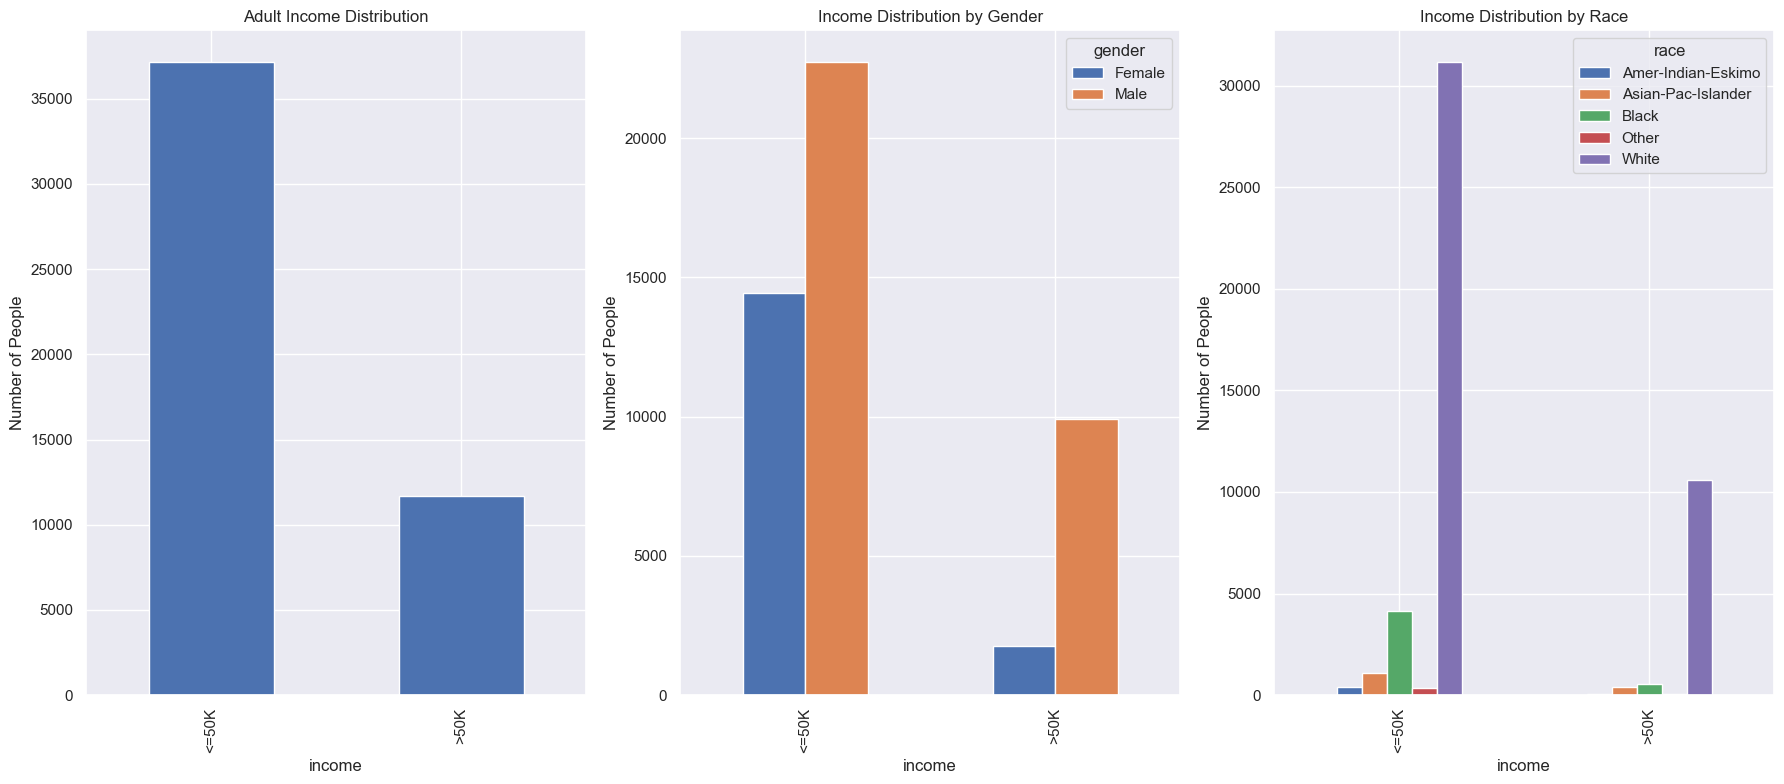

In [54]:
# Your answer here

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# bar chart of the target variable
df['income'].value_counts().plot(kind='bar', ax=axes[0], title='Adult Income Distribution')
axes[0].set_ylabel('Number of People')

# bar chart of the target variable divided by gender
gender_income = df.groupby(['income', 'gender']).size().unstack().plot(kind='bar', ax=axes[1], title='Income Distribution by Gender')
axes[1].set_ylabel('Number of People')

# bar chart of the target variable divided by race
race_income = df.groupby(['income', 'race']).size().unstack().plot(kind='bar', ax=axes[2], title='Income Distribution by Race')
axes[2].set_ylabel('Number of People')


plt.tight_layout()
plt.show()

- The target variable is imbalanced, we have more examples with income that are less or equal to 50k.
- Income distribution is imbalanced across genders, both males and females have a higher count in the <=50K income group. Also, the number of males earning >50K is substantially higher than that of females. This highlights potential gender inequality in income levels within the dataset
- Income distribution is imbalanced across races. The white people has a much higher representation in the dataset, showing in both <= 50k and >50k groups, compared to other races. Black and Other races fall more in the <=50K category, but are underrepresented in the >50k category. And Asian/Pacific Islander and White individuals have a relatively higher proportion in the >50K category than Black and Other races. The significant disparities could indicate racial biases in income distribution.

### A biased classifier

We can expect that a classifier trained on this kind of data will show some problematic behaviors when assigning an individual to a predicted income level. Let's visualize this using a random forest classifier.

In [55]:
# STEP 1
# Run this cell create training and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [56]:
# STEP 2
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_test_transformed = ct.transform(X_test).toarray()

In [57]:
# You may use this lines to check the result
# pd.DataFrame(X_train_transformed, columns=column_names)
# pd.DataFrame(X_test_transformed, columns=column_names)

In [58]:
# STEP 3
# Run this cell to train a random forest classifer. The hyperparameters have been pre-selected

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed, y_train)

How good is this classifier? Let's check its accuracy, by running the cells below:

In [59]:
clf.score(X_train_transformed, y_train)

0.9064318932990143

In [60]:
clf.score(X_test_transformed, y_test)

0.8624172524397734

Finally, let's see what features are considered important by the classifier.

<Axes: >

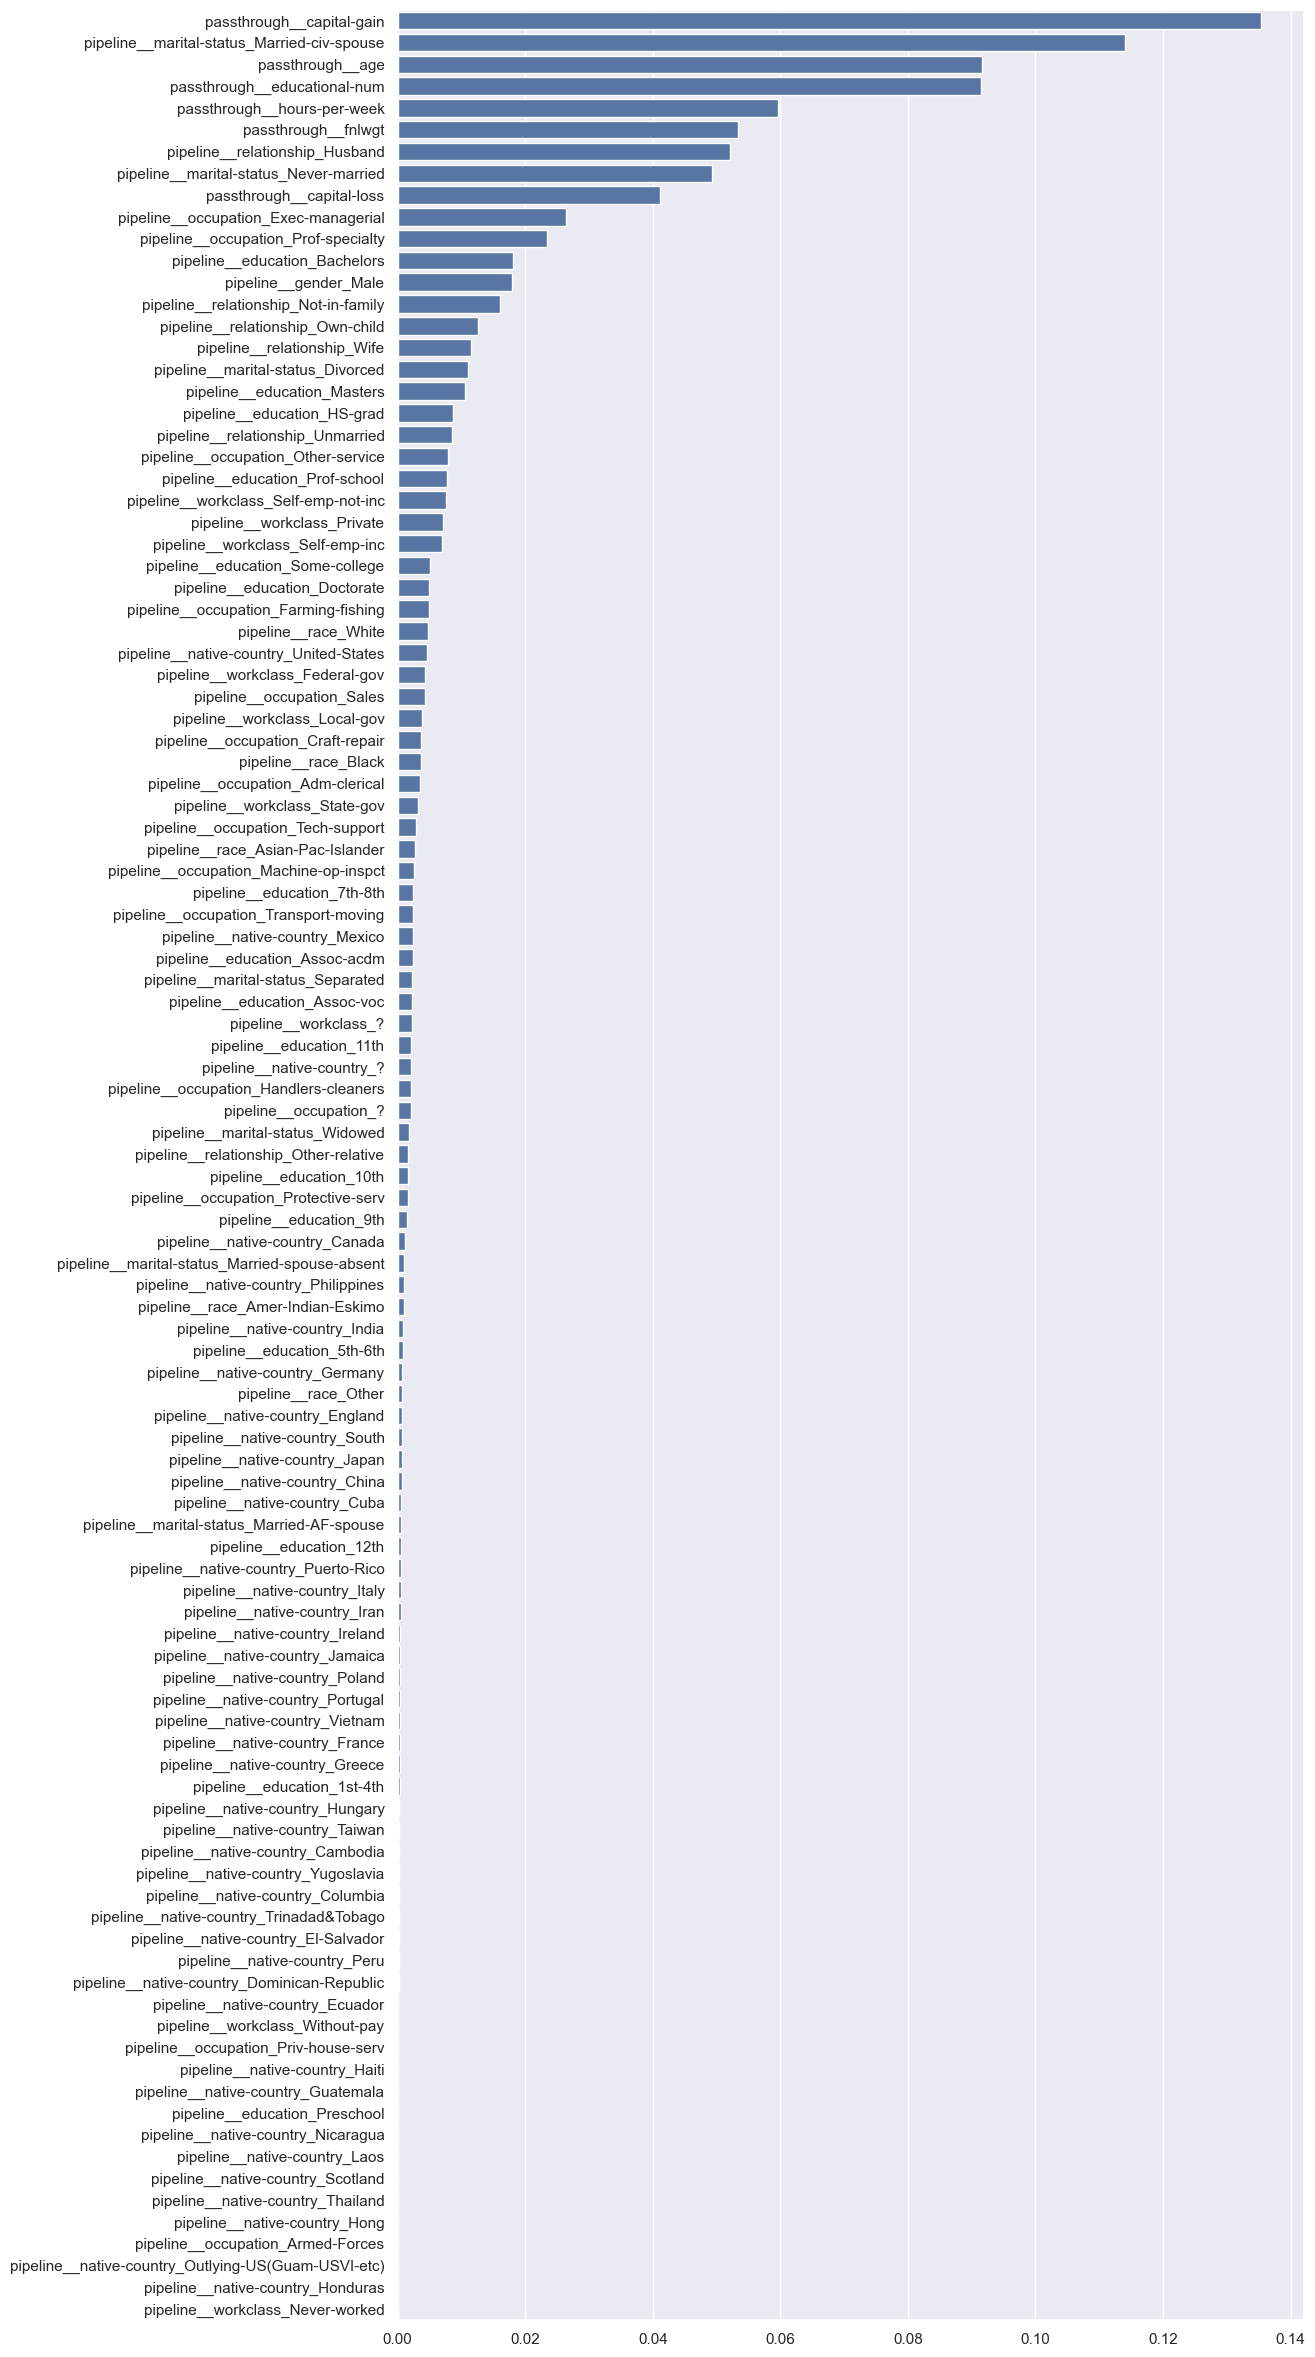

In [61]:
import seaborn as sns

feature_importances = clf.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ct.get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

#### Question 2
What are the most important features for this classifier? Do they include protected characteristics, such as race or gender?

These are the five most important features shown in the chart: capital-gain, marital-status, age, educational-num, hours-per-week.
<br>
The protected characteristics: race and gender, also shown in the cart. The features related to gender and races, like gender_Male, native_country_ and race_White, race_Black,etc. are considered by the classifier. These protected characteristics should be handled cautiously in predictive modeling to avoid perpetuating bias.


#### Question 3

From Assignment 3, we have learned that a classifier may perform well in terms of accuracy, but being unfair to protected groups in the dataset. Use what you have learned in Assignment 3 and **evaluate this classifier for fairness in treating the two gender groups included in this dataset.** In particular, do the following: 

- Compute the 6 fairness metrics and the Average Distance from the Reference on training and test sets. You may reuse portions of code you have included in Assignment 3.
- Comment on the results, providing an interpretation for each computed metric; how different is the treatment of the two groups? Is one (or more) of the metrics particularly concerning?

Here is a recap of the fairness metrics:
1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

In [62]:
# Your answer here (you may add more cells)
from sklearn.metrics import confusion_matrix

def compute_fairness_metrics(y_true, y_pred, protected_variable):
    group1_idx = protected_variable == 'Male'
    group2_idx = protected_variable == 'Female'

    tn1, fp1, fn1, tp1 = confusion_matrix(y_true[group1_idx], y_pred[group1_idx]).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(y_true[group2_idx], y_pred[group2_idx]).ravel()

    pprd = (tp1 + fp1) / (tn1 + fn1 + tp1 + fp1) / ((tp2 + fp2) / (tn2 + fn2 + tp2 + fp2))
    ppgrd = (tp1 / (tp1 + fp1)) / (tp2 / (tp2 + fp2))
    fdrd = (fp1 / (tp1 + fp1)) / (fp2 / (tp2 + fp2))
    fprd = (fp1 / (tn1 + fp1)) / (fp2 / (tn2 + fp2))
    ford = (fn1 / (tn1 + fn1)) / (fn2 / (tn2 + fn2))
    fnrd = (fn1 / (fn1 + tp1)) / (fn2 / (fn2 + tp2))

    # average distance from the reference 
    average_distance = (abs(pprd - 1) + abs(ppgrd - 1) + abs(fdrd - 1) +
                        abs(fprd - 1) + abs(ford - 1) + abs(fnrd - 1)) / 6

    return {
        'PPRD': pprd,
        'PPGRD': ppgrd,
        'FDRD': fdrd,
        'FPRD': fprd,
        'FORD': ford,
        'FNRD': fnrd,
        'Average Distance from Reference': average_distance
    }



# generate predictions
y_train_pred = clf.predict(X_train_transformed)
y_test_pred = clf.predict(X_test_transformed)

gender_train = X_train['gender']
gender_test = X_test['gender']

fairness_metrics_train = compute_fairness_metrics(y_train, y_train_pred, gender_train)
fairness_metrics_test = compute_fairness_metrics(y_test, y_test_pred, gender_test)

# convert to DataFrame 
df_fairness_metrics_train = pd.DataFrame([fairness_metrics_train], index=["Training Set"])
df_fairness_metrics_test = pd.DataFrame([fairness_metrics_test], index=["Testing Set"])

print(df_fairness_metrics_train)
print(df_fairness_metrics_test)


                  PPRD     PPGRD      FDRD      FPRD      FORD      FNRD  \
Training Set  2.825373  0.917208  2.564594  9.265201  3.906744  1.172959   

              Average Distance from Reference  
Training Set                          2.46961  
                 PPRD    PPGRD     FDRD      FPRD      FORD      FNRD  \
Testing Set  3.462238  0.95536  1.19466  5.298535  2.843385  0.825256   

             Average Distance from Reference  
Testing Set                         1.503034  


These metrics suggest that the classifier significantly favors males in predicting higher incomes (>50k), especially noticeable in the high disparities in PPRD and FPRD across both sets: <br>
Predicted Positive Rate Disparity (PPRD) in training set is 2.825373, and 3.462238 in test set, showing greater bias in predicting higher income for males over females. <br>
False Positive Rate Disparity (FPRD) in training set is 9.265201:, and 5.298535 in test set, indicating that males are over 9 times more likely (in training set) and 5 times more likely (in test set) to be falsely predicted as ">50K" compared to their actual lower incomes than females. This is a critical area of concern showing significant bias.

The significant values in FDRD and FORD also suggest a high tendency to overestimate males' earning, while underestimating or omitting them when they actually qualified for higher incomes compared to females. These results are particularly concerning because they indicate biases that could have real-world implications for decision-making processes.

## Debiasing techniques: dropping protected characteristics

A first idea to fix this issue could be dropping the protected characteristics from our dataset before training the classifier. Let's try this out and see if there is any improvement.

#### Question 4
1. Drop race, gender and native country from training and test set (we are focusing on gender but we will drop race and native country for good measure).
2. Transform the cleaned dataset using one-hot encoding.
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous one. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Note that, to compare fairness, you will need to have a way to identify the gender of each sample, even though you are not using this feature for classification.
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the first one?

**Hint:** steps 2, 3 and 5 can be completed by tweaking the starting code given at the beginning of this assignment. Ask a TA or instructor if you need help in doing that.

In [63]:
# Your answer here (you may add more cells)

# 1: drop race, gender and native country
X_train_cleaned = X_train.drop(columns=['gender', 'race', 'native-country'])
X_test_cleaned = X_test.drop(columns=['gender', 'race', 'native-country'])

In [64]:
# 2. transform the cleaned dataset
# update the list of categorical features
categorical_feats_cleaned = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                    #  "race",
                    #  "gender",
                    #  "native-country",
                     ]  # Apply one-hot encoding

ct_cleaned = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats_cleaned,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

# Transform the data
X_train_transformed_cleaned = ct_cleaned.fit_transform(X_train_cleaned)
X_test_transformed_cleaned = ct_cleaned.transform(X_test_cleaned)

In [65]:
# 3. Re-train the random forest classifier.

clf_cleaned = RandomForestClassifier(random_state=0, max_depth=19, n_estimators=100)
clf_cleaned.fit(X_train_transformed_cleaned, y_train)

RandomForestClassifier(max_depth=19, random_state=0)

In [66]:
# calculate new accuracies
accuracy_train_cleaned = clf_cleaned.score(X_train_transformed_cleaned, y_train)
accuracy_test_cleaned = clf_cleaned.score(X_test_transformed_cleaned, y_test)

# compare
accuracy_train_original = clf.score(X_train_transformed, y_train)
accuracy_test_original = clf.score(X_test_transformed, y_test)

accuracy_comparison = pd.DataFrame({
    "Model": ["Original", "Cleaned"],
    "Training Set Accuracy": [accuracy_train_original, accuracy_train_cleaned],
    "Testing Set Accuracy": [accuracy_test_original, accuracy_test_cleaned]
})
accuracy_comparison


,Model,Training Set Accuracy,Testing Set Accuracy
0,Original,0.906432,0.862417
1,Cleaned,0.918541,0.860302


The model which dropped the gender, race, and native country features, shows a slight improvement in training set accuracy, but a minimal decrease in testing set accuracy. This suggests that removing the protected attributes has not detrimentally impacted the classifier's ability to generalize, but rather has slightly improved its learning from the training data.

In [67]:
# 4. Compare Fairness
y_train_pred_cleaned = clf_cleaned.predict(X_train_transformed_cleaned)
y_test_pred_cleaned = clf_cleaned.predict(X_test_transformed_cleaned)

# use the separately stored gender data (genders_train and genders_test) to calculate fairness metrics.
# to identify the gender of each sample, even though not using this feature for classification. 
fairness_metrics_train_cleaned = compute_fairness_metrics(y_train, y_train_pred_cleaned, gender_train)
fairness_metrics_test_cleaned = compute_fairness_metrics(y_test, y_test_pred_cleaned, gender_test)

# convert to pd.df and print
df_fairness_metrics_train_cleaned = pd.DataFrame([fairness_metrics_train_cleaned], index=["Training Set_cleaned"])
df_fairness_metrics_test_cleaned = pd.DataFrame([fairness_metrics_test_cleaned], index=["Testing Set_cleaned"])

print(df_fairness_metrics_train_cleaned)
print(df_fairness_metrics_test_cleaned)


                          PPRD     PPGRD      FDRD       FPRD      FORD  \
Training Set_cleaned  2.804414  0.930464  2.965421  10.633812  3.937625   

                          FNRD  Average Distance from Reference  
Training Set_cleaned  1.179591                         2.765067  
                         PPRD     PPGRD     FDRD    FPRD      FORD     FNRD  \
Testing Set_cleaned  3.316711  0.996196  1.01279  4.3031  2.839551  0.82253   

                     Average Distance from Reference  
Testing Set_cleaned                         1.275571  


The fairness metrics show minimal change in disparities between gender groups in both training and test sets, suggesting the fundamental biases related to gender remain largely unchanged. This indicates that biases may be systemic within the dataset and embedded in other features correlated with the protected attributes. Therefore, simply removing these attributes doesn't necessarily eliminate the bias.

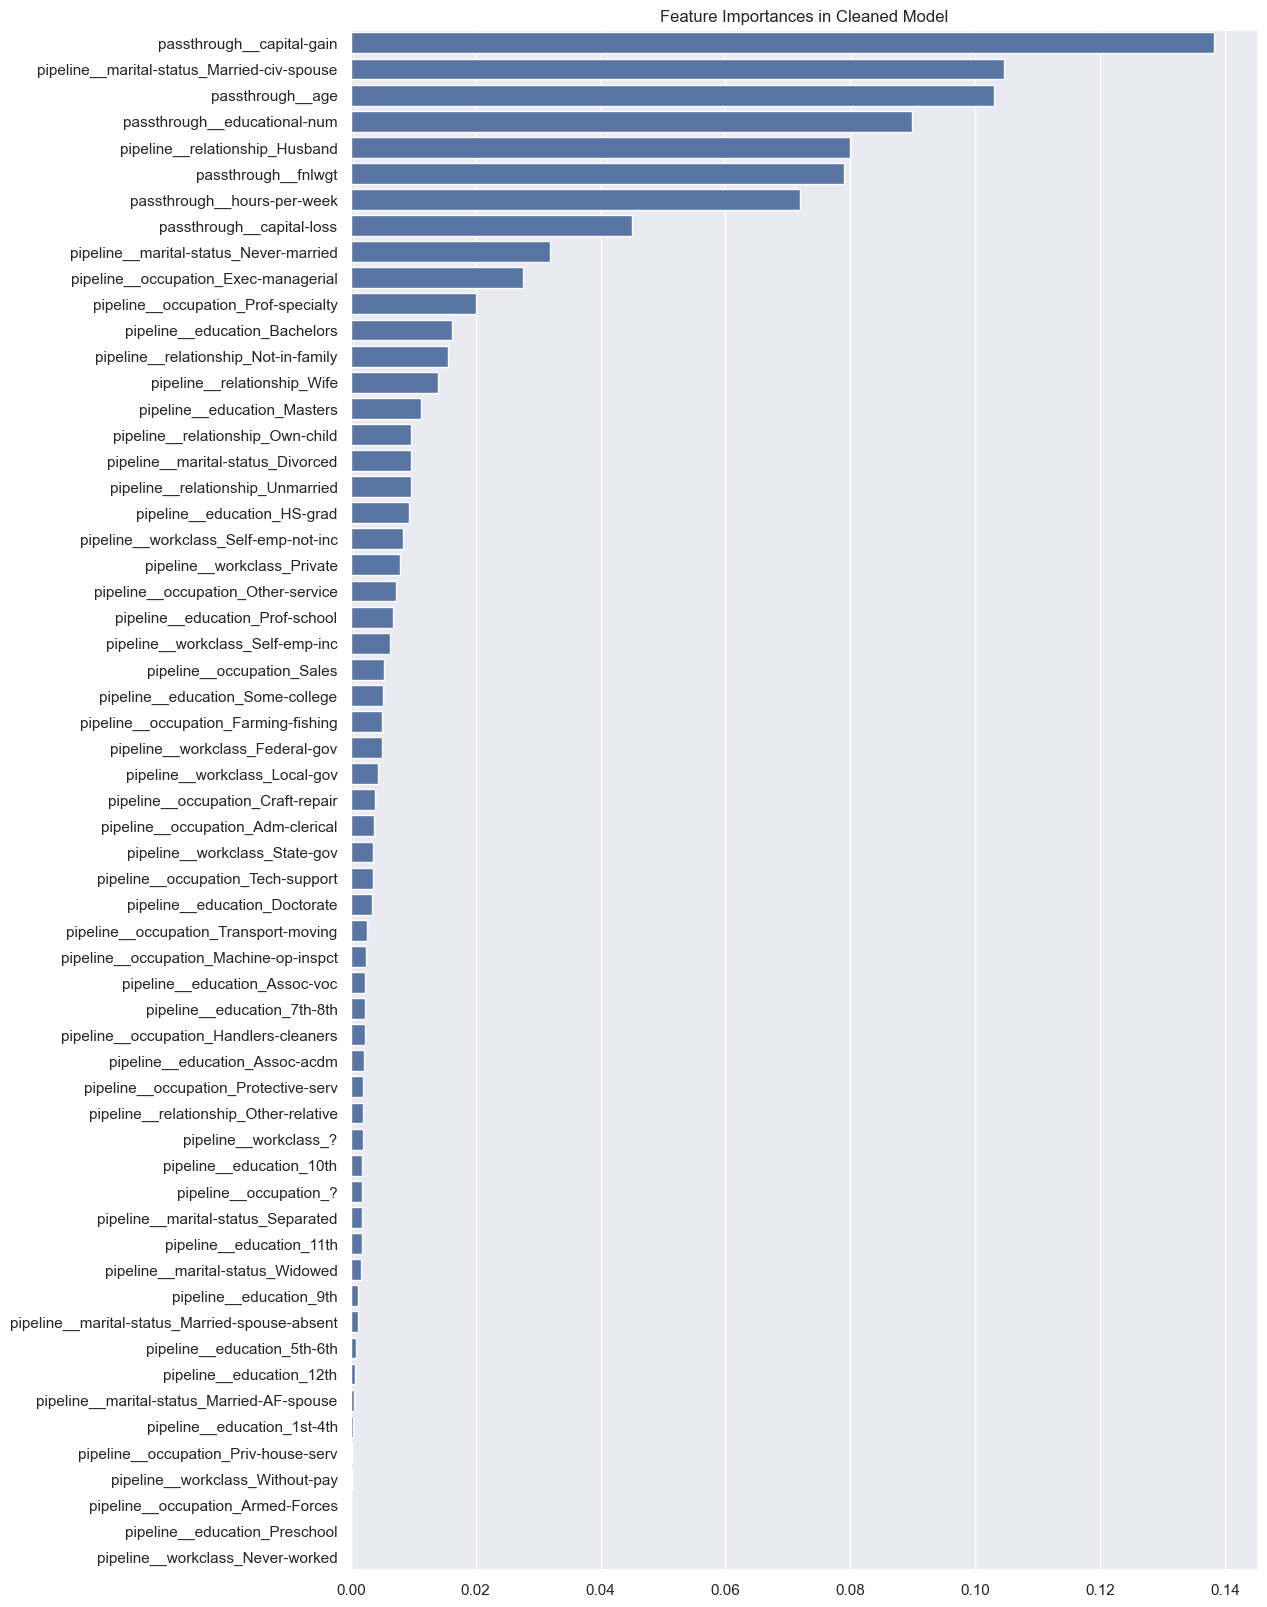

In [68]:
# 5. plot of the feature importance
feature_importances_cleaned = clf_cleaned.feature_importances_
sorted_indices_cleaned = feature_importances_cleaned.argsort()[::-1]
sorted_feature_names_cleaned = ct_cleaned.get_feature_names_out()[sorted_indices_cleaned]
sorted_importances_cleaned = feature_importances_cleaned[sorted_indices_cleaned]

sns.set(rc={'figure.figsize':(11.7,20)})
sns.barplot(x=sorted_importances_cleaned, y=sorted_feature_names_cleaned)
plt.title('Feature Importances in Cleaned Model')
plt.show()

Changes in Feature Importance
- Original Model: Important features included capital gain, age, marital status, education, and work hours. The model also showed significance in protected attributes like gender and race.
- Cleaned Model: also show capital gain, age, marital status, education, and work hours as important features. And more emphasis on other demographic, martial status (husband or wife), which can be a proxy for gender, and occupational features, potentially compensating for the absence of the direct gender and race indicators.
The new feature importance plot show importance on other indicators that might still be proxies for the removed attributes. If these proxies (like certain occupations or marital statuses) carry the same societal biases, they will continue to influence the model in similar ways.


## Debiasing techniques: undersampling

As you should have seen when exploring the dataset, the groups of males and females who make more or less than \\$50k are of very different sizes. This alone may have a significant impact on the way the classifier is trained, by teaching it that some groups are much more likely to make more than \\$50k than others.

Let's try to fix this problem by creating a more balanced training set.

#### Question 5
1. Run the cell below to create a new training set by selecting a subset of samples from the original one, in which the groups of males and females who make more or less than \\$50k are of equal size. To use the maximum number of training samples possible, the size of each group should be equal to the size of the smallest of these groups in the original dataset. **What is the size of each group, and of the final training set?**
2. Separate features from target, and transform the cleaned dataset using one-hot encoding. **Remeber to re-transform the test set accordingly!**
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?


In [69]:
# Check the distribution of gender and income
gender_distribution = train_df['gender'].value_counts()
income_distribution = train_df['income'].value_counts()

# Create balanced subsets
balanced_subsets = []
smallest = train_df.shape[0]

# Finding size of smallest subset by gender and income
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        if train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0] < smallest:
            smallest = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0]
    
# Sampling subsets 
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        subset = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)]
        subset = subset.sample(smallest)  # Sample to match the minimum count
        balanced_subsets.append(subset)
        
# Merge the balanced subsets to create the final balanced dataset
balanced_df = pd.concat(balanced_subsets)

In [70]:
# Your answer here (you may add more cells)

# 1.
print("Size of each group:", smallest)
print("Total size of the final balanced training set:", balanced_df.shape[0])

Size of each group: 1249
Total size of the final balanced training set: 4996


In [71]:
# 2. Separate Features from Target, and Transform the Dataset

# separate features and target
X_balanced = balanced_df.drop(columns='income')
y_balanced = balanced_df['income']

X_balanced_transformed = ct.transform(X_balanced)

# re-transform the test set
X_test_transformed = ct.transform(X_test)

In [72]:
# 3 Re-train the random forest classifier
clf_balanced = RandomForestClassifier(random_state=0, max_depth=19, n_estimators=100)
clf_balanced.fit(X_balanced_transformed, y_balanced)

# accuracy on the transformed test set
accuracy_train_balanced = clf_balanced.score(X_balanced_transformed, y_balanced)
accuracy_test_balanced = clf_balanced.score(X_test_transformed, y_test)

# compare accuracy
accuracy_comparison2 = pd.DataFrame({
    "Model": ["Original", "Cleaned", "Balanced"],
    "Training Set Accuracy": [accuracy_train_original, accuracy_train_cleaned, accuracy_train_balanced],
    "Testing Set Accuracy": [accuracy_test_original, accuracy_test_cleaned, accuracy_test_balanced]
})
accuracy_comparison2

,Model,Training Set Accuracy,Testing Set Accuracy
0,Original,0.906432,0.862417
1,Cleaned,0.918541,0.860302
2,Balanced,0.960568,0.807548


The balanced model shows improvement in training set accuracy, but a decrease in testing set accuracy. This suggests that while the model performs exceptionally well on balanced trainig dataset, it struggles to generalize this performance to the realistically imbalanced test dataset.

In [73]:
# 4. Compare Fairness
y_train_balanced_pred = clf_balanced.predict(X_balanced_transformed)
y_test_balanced_pred = clf_balanced.predict(X_test_transformed)

# gender_train = X_train['gender']
gender_balanced_train = balanced_df['gender']
gender_test = X_test['gender']

fairness_metrics_train_balanced = compute_fairness_metrics(y_balanced, y_train_balanced_pred, gender_balanced_train)
fairness_metrics_test_balanced = compute_fairness_metrics(y_test, y_test_balanced_pred, gender_test)

# convert to pd.df and print
df_fairness_metrics_train_balanced = pd.DataFrame([fairness_metrics_train_balanced], index=["Training Set_balanced"])
df_fairness_metrics_test_balanced = pd.DataFrame([fairness_metrics_test_balanced], index=["Testing Set_balanced"])

print(df_fairness_metrics_train_balanced)
print(df_fairness_metrics_test_balanced)

                           PPRD     PPGRD      FDRD  FPRD      FORD      FNRD  \
Training Set_balanced  1.036979  0.951022  2.507284   2.6  2.021893  1.944444   

                       Average Distance from Reference  
Training Set_balanced                          0.85993  
                          PPRD     PPGRD      FDRD      FPRD      FORD  \
Testing Set_balanced  1.887153  1.445049  0.680881  1.646011  4.640216   

                          FNRD  Average Distance from Reference  
Testing Set_balanced  1.228899                         1.027741  


The fairness metrics do not show significant improvement, and the persistent issues across fairness metrics, especially in False Positive Rate Disparity (FPRD) and False Discovery Rate Disparity (FDRD), imply that the classifier may still be learning biased patterns. These could be associated with other features that correlate with the removed or balanced attributes.

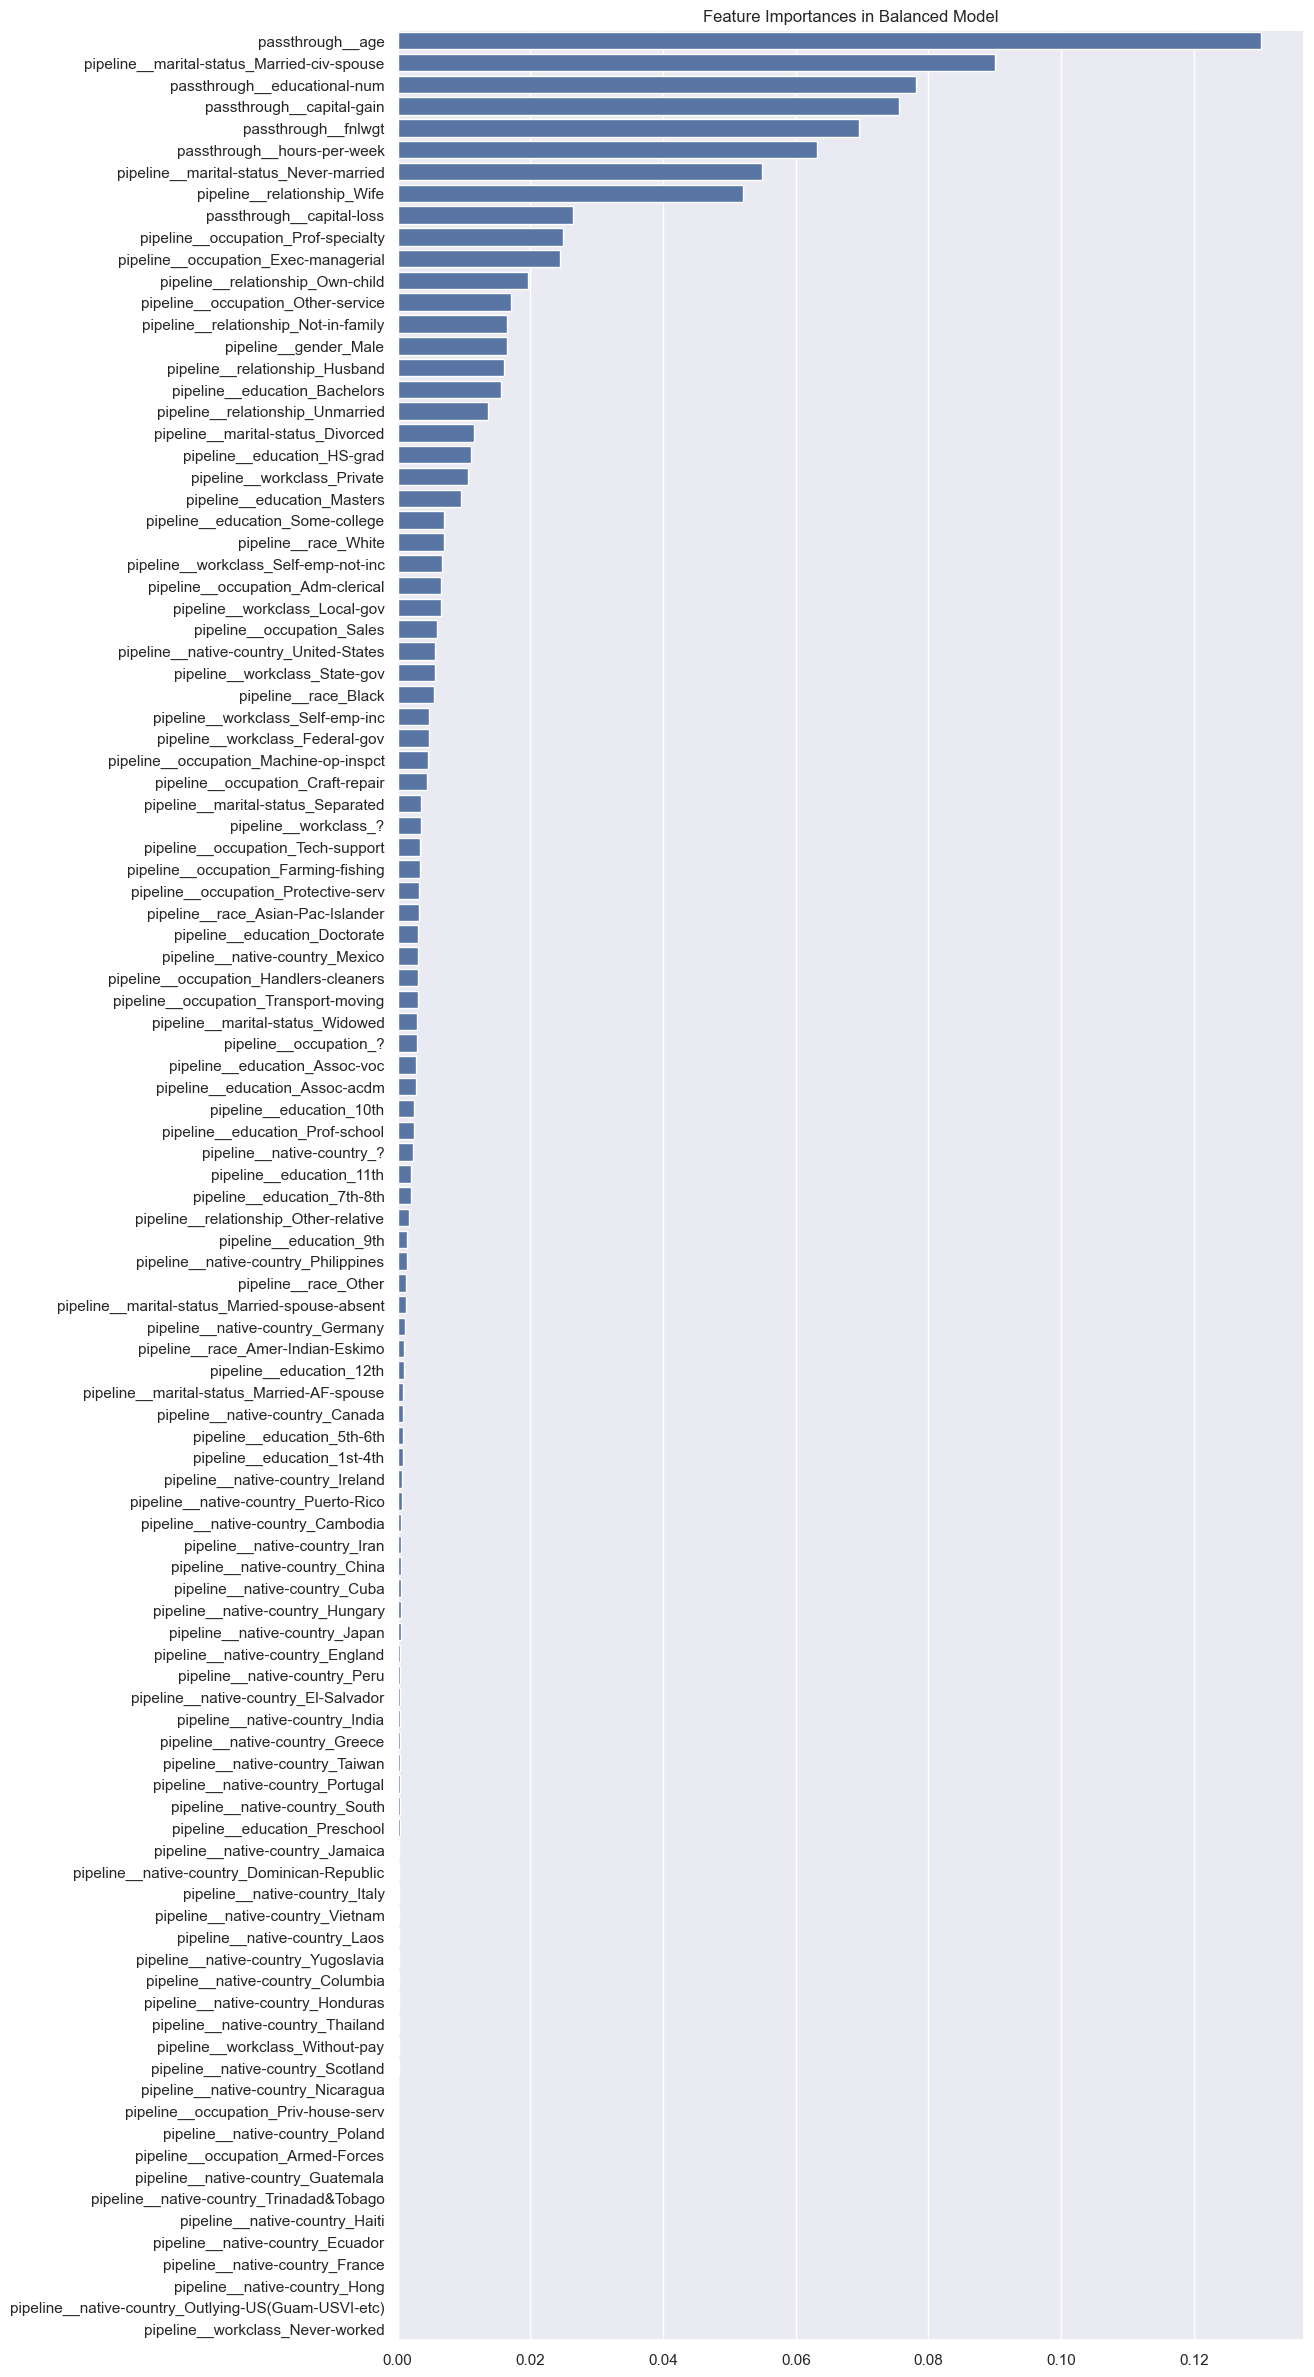

In [92]:
# 5. plot of the feature importance
feature_importances_balanced = clf_balanced.feature_importances_
sorted_indices_balanced = feature_importances_balanced.argsort()[::-1]
sorted_feature_names_balanced = ct.get_feature_names_out()[sorted_indices_balanced]
sorted_importances_balanced = feature_importances_balanced[sorted_indices_balanced]

sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances_balanced, y=sorted_feature_names_balanced)
plt.title('Feature Importances in Balanced Model')
plt.show()

The balanced model also include capital gain, age, marital status, education, and work hours as important features, which with different order. The bar chart above also show that the balanced model (undersampling) focus less on features that were previously overshadowing due to imbalance, for example race, gender features.

## Debiasing techniques: oversampling (with SMOTE)

Another way to create a more balanced training set, but without sacrificing training samples, is by *oversampling*, which means artificially increasing the size of the training set with "fake" samples. This can be achieved mainly in two ways:
1. By resampling (replicating) samples from the original training set, or
2. By introducing artificial *new* samples, similar enough to those included in the original training set

The Synthetic Minority Oversampling Technique (SMOTE) seen in class falls in the second group. In this portion of the assignment, you will create a more balanced dataset using SMOTE (specifically [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html), a version of SMOTE that allows working with categorical variables).

#### Question 6
1. Run the cell below to create a more balanced training set using SMOTE. Note that a large portion of code is replicated to guarantee that the correct data is used, and not one modified in previous cells. The actual rebalancing all happens in the last 2 lines.
2. Explore the new training set, and provide the following information: what is the size of the new training set? Is the target variable balanced? How many samples are classified as >\\$50, and how many as <=\\$50k? Is the target variable balanced across protected groups, or at least more balanced than before? How many males and females are classified as >\\$50, and how many as <=\\$50k?
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?

In [75]:
from imblearn.over_sampling import SMOTENC

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

oversample = SMOTENC(categorical_features=categorical_feats, random_state=0)

X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)


In [76]:
# Transformation applied after oversampling

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"


ctSMOTE = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore",drop="if_binary",sparse_output=False),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ctSMOTE.fit_transform(X_train_SMOTE)
X_test_transformed = ctSMOTE.transform(X_test)

# Column names, if needed
column_names = list(
    ctSMOTE.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

# X_train_transformed and X_test_transformed can now be used to answer the questions above

In [77]:
# Your answer here (you may add more cells)

# 2. Explore the new training set
# Print the size of the new training set after SMOTE
print("Size of the new training set after SMOTE:", X_train_SMOTE.shape[0])

# Checking balance of the target variable
balance_after_smote = y_train_SMOTE.value_counts()
print("Balance of the target variable after SMOTE:")
print(balance_after_smote)

# Checking balance of the target variable across gender groups
smote_df = pd.DataFrame(X_train_SMOTE, columns=X_train.columns)
smote_df['income'] = y_train_SMOTE

# Check balance across gender
gender_income_distribution = smote_df.groupby(['gender', 'income']).size().unstack()
print("Distribution of income across gender after SMOTE:")
print(gender_income_distribution)

Size of the new training set after SMOTE: 51968
Balance of the target variable after SMOTE:
income
<=50K    25984
>50K     25984
Name: count, dtype: int64
Distribution of income across gender after SMOTE:
income  <=50K   >50K
gender              
Female  10074   1969
Male    15910  24015


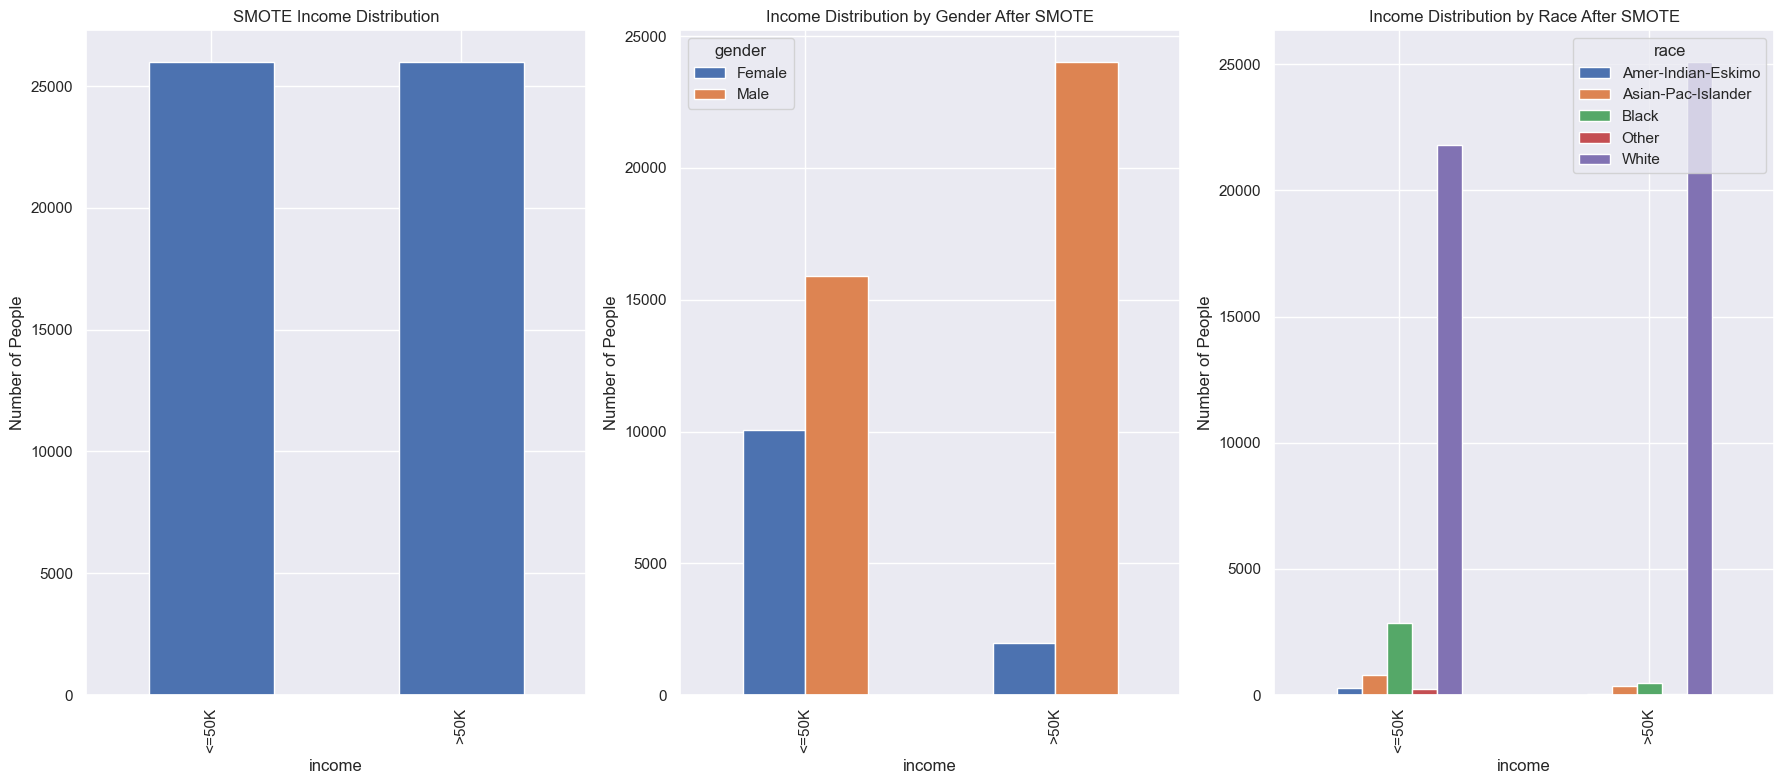

In [78]:
X_train_SMOTE_df = pd.DataFrame(X_train_SMOTE, columns=X_train.columns)  # Ensure column names match
X_train_SMOTE_df['income'] = y_train_SMOTE  # Add the target variable back to the DataFrame


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Bar chart of the target variable
X_train_SMOTE_df['income'].value_counts().plot(kind='bar', ax=axes[0], title='SMOTE Income Distribution')
axes[0].set_ylabel('Number of People')

# Bar chart of the target variable divided by gender
X_train_SMOTE_df.groupby(['income', 'gender']).size().unstack().plot(kind='bar', ax=axes[1], title='Income Distribution by Gender After SMOTE')
axes[1].set_ylabel('Number of People')

# Since race was also considered a protected group, we include it if needed:
if 'race' in X_train_SMOTE_df.columns:
    X_train_SMOTE_df.groupby(['income', 'race']).size().unstack().plot(kind='bar', ax=axes[2], title='Income Distribution by Race After SMOTE')
    axes[2].set_ylabel('Number of People')
else:
    axes[2].set_visible(False)  # Hide the third axis if no race data

plt.tight_layout()
plt.show()


The after-SMOTE data shows that the target variable is more balancedthan before. This not only aids in fairer model development.

In [79]:
# 3. Re-train the random forest classifier
clf_SMOTE = RandomForestClassifier(random_state=0, max_depth=19, n_estimators=100).fit(X_train_transformed, y_train_SMOTE)

In [80]:
# 4. Compare Accuracy and Fairness

# accuracy on the SMOTE model
accuracy_train_SMOTE = clf_SMOTE.score(X_train_transformed, y_train_SMOTE)
accuracy_test_SMOTE = clf_SMOTE.score(X_test_transformed, y_test)

# compare accuracy
accuracy_comparison3 = pd.DataFrame({
    "Model": ["Original", "Cleaned", "Balanced", "SMOTE"],
    "Training Set Accuracy": [accuracy_train_original, accuracy_train_cleaned, accuracy_train_balanced, accuracy_train_SMOTE],
    "Testing Set Accuracy": [accuracy_test_original, accuracy_test_cleaned, accuracy_test_balanced, accuracy_test_SMOTE]
})
accuracy_comparison3

,Model,Training Set Accuracy,Testing Set Accuracy
0,Original,0.906432,0.862417
1,Cleaned,0.918541,0.860302
2,Balanced,0.960568,0.807548
3,SMOTE,0.920316,0.841329


The SMOTE model provided a good trade-off between the training and testing accuracy among the previous models.

In [81]:
# 4. Compare Fairness
y_train_SMOTE_pred = clf_SMOTE.predict(X_train_transformed)
y_test_SMOTE_pred = clf_SMOTE.predict(X_test_transformed)

# gender_train = X_train['gender']
gender_SMOTE_train = X_train_SMOTE['gender']
gender_test = X_test['gender']

fairness_metrics_train_SMOTE = compute_fairness_metrics(y_train_SMOTE, y_train_SMOTE_pred, gender_SMOTE_train)
fairness_metrics_test_SMOTE = compute_fairness_metrics(y_test, y_test_SMOTE_pred, gender_test)

# convert to pd.df and print
df_fairness_metrics_train_SMOTE = pd.DataFrame([fairness_metrics_train_SMOTE], index=["Training Set_SMOTE"])
df_fairness_metrics_test_SMOTE = pd.DataFrame([fairness_metrics_test_SMOTE], index=["Testing Set_SMOTE"])

print(df_fairness_metrics_train_SMOTE)
print(df_fairness_metrics_test_SMOTE)

                        PPRD    PPGRD      FDRD       FPRD      FORD  \
Training Set_SMOTE  4.169556  0.97473  1.283622  11.234898  2.798013   

                        FNRD  Average Distance from Reference  
Training Set_SMOTE  0.320791                         2.698428  
                       PPRD     PPGRD      FDRD      FPRD      FORD      FNRD  \
Testing Set_SMOTE  4.714439  0.841606  1.467263  8.861199  2.007532  0.475955   

                   Average Distance from Reference  
Testing Set_SMOTE                         2.288812  


Fairness is improved in training in the SMOTE model, but translating these improvements effectively into the testing scenario remains challenging. The disparities in fairness metrics indicate that more sophisticated methods or careful tuning might be necessary to balance both accuracy and fairness.

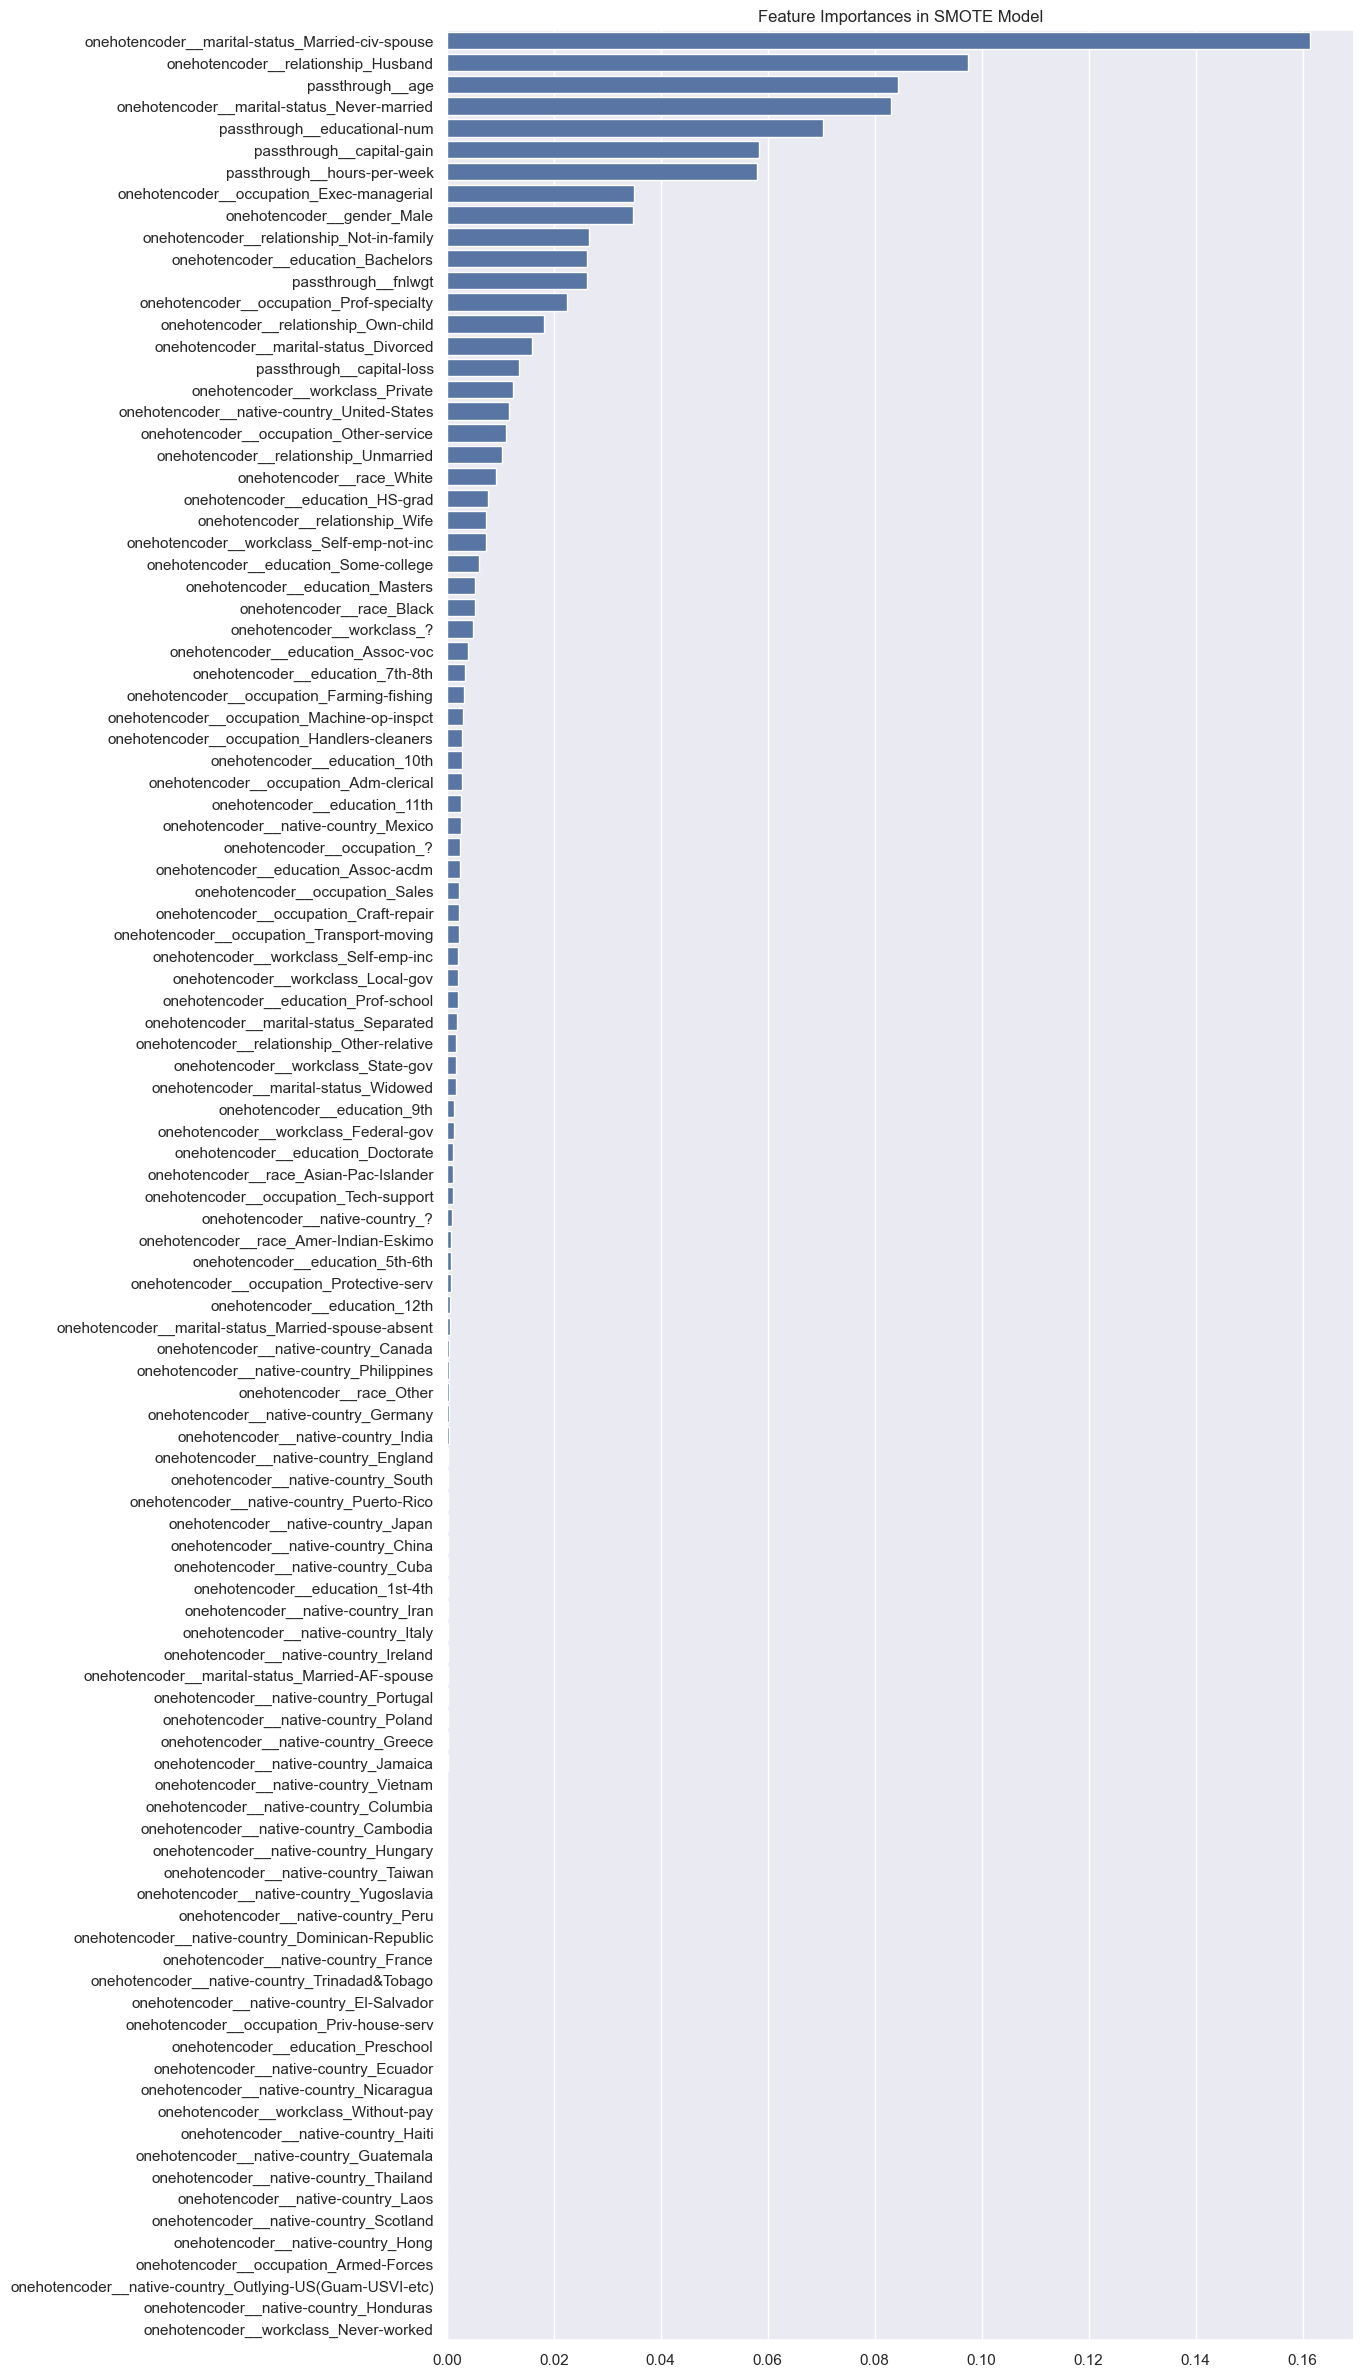

In [93]:
# 5. plot of the feature importance
feature_importances_SMOTE = clf_SMOTE.feature_importances_
sorted_indices_SMOTE = feature_importances_SMOTE.argsort()[::-1]
sorted_feature_names_SMOTE = ctSMOTE.get_feature_names_out()[sorted_indices_SMOTE]
sorted_importances_SMOTE = feature_importances_SMOTE[sorted_indices_SMOTE]

sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances_SMOTE, y=sorted_feature_names_SMOTE)
plt.title('Feature Importances in SMOTE Model')
plt.show()

Each method of addressing bias shifts the model's focus across various features. SMOTE reintroduce or shift emphasis on marital status, affecting the model's performance.

## Equalized odd post processing

An alternative to the methods seen so far (which may produce unsatisfactory results), is applying post-processing to the predictions of the classifier, so that they optimize equalized odds (whether the TPR and FPR are on par across groups).

`aif360`, a popular open-source library dedicated to detecting and mitigating bias in machine learning models, includes [`EqOddsPostprocessing`](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html), a function to performe equalized odds post-processing. The function is slightly more intricate to use than others you have used so far (typically from `sklearn`), so we will see together how to apply it on the test (you may try and replicate this on the training set for your own practice).

In [83]:
# Run this cell to reset training and test sets (and clear accidental prior changes)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [84]:
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()
X_test_transformed = ct.transform(X_test).toarray()

In [85]:
# Convert numpy arrays to pandas dataframes

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_train_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=column_names)

In [86]:
# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_df, y_train)

# Get predictions for test set 
y_pred = clf.predict(X_test_df)

# So far, all this is the same as the biased classifier we started with 

In [87]:
# Convert test data into a BinaryLabelDataset, necessary to work in aif360

from aif360.datasets import BinaryLabelDataset

X_test_df = X_test_df.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_binary = y_test.map({'>50K': 1, '<=50K': 0})  # Map categorical values to binary

test_bld = BinaryLabelDataset(df=pd.concat([X_test_df, y_binary], axis=1),
                              label_names=['income'],
                              protected_attribute_names=['gender_Male'])

In [88]:
# Create another dataset with predicted labels for comparison
test_pred_bld = test_bld.copy()

# Convert to binary label (e.g., class 2 is positive, others are negative)
y_pred_binary = np.where(y_pred == '>50K', 1, 0)

test_pred_bld.labels = y_pred_binary.reshape(-1, 1)

In [89]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Initialize EqOddsPostprocessing
eq_odds = EqOddsPostprocessing(unprivileged_groups=[{'gender_Male': 0}],
                               privileged_groups=[{'gender_Male': 1}])


In [90]:
# Fit the EqOddsPostprocessing model
eq_odds = eq_odds.fit(test_bld, test_pred_bld)

# Get new fair predictions
fair_pred_bld = eq_odds.predict(test_pred_bld)

# Convert predictions back to array
fair_predictions = fair_pred_bld.labels

In [91]:
fair_predictions_cat = np.where(fair_predictions == 1, '>50K', '<=50K')
fair_predictions_cat 

array([['<=50K'],
       ['<=50K'],
       ['<=50K'],
       ...,
       ['<=50K'],
       ['<=50K'],
       ['<=50K']], dtype='<U5')

`fair_predictions_cat` now includes the post-processed predictions, after equalized odds postprocessing. 

#### Question 7

Compute accuracy and fairness of this new predictions, and compare the results to the previous ones. Do we see any improvement? Is this technique more or less effective than the others tried before?

In [100]:
# Compute accuracy for the post-processed predictions
accuracy_test_eq_odds = accuracy_score(y_test, fair_predictions_cat)
# Post-processing is applied post-training, no training accuracy applicable

# Append to the existing DataFrame for comparison
new_row_df = pd.DataFrame([['EqOdds Post-Processed', None, accuracy_test_eq_odds]], 
                          columns=['Model', 'Training Set Accuracy', 'Testing Set Accuracy'])

# Concatenate the new row DataFrame to the existing accuracy comparison DataFrame
accuracy_comparison4 = pd.concat([accuracy_comparison3, new_row_df], ignore_index=True)

accuracy_comparison4

,Model,Training Set Accuracy,Testing Set Accuracy
0,Original,0.906432,0.862417
1,Cleaned,0.918541,0.860302
2,Balanced,0.960568,0.807548
3,SMOTE,0.920316,0.841329
4,EqOdds Post-Processed,NaN,0.839077


In [101]:
# Assuming 'gender_test' aligns with 'y_test'
# Make sure 'gender_test' is reset to match the post-processed predictions
gender_test = gender_test.reset_index(drop=True)

# Compute fairness metrics using the post-processed predictions
fairness_metrics_test_eq_odds = compute_fairness_metrics(y_test, fair_predictions_cat.reshape(-1,), gender_test)

# Convert to DataFrame
df_fairness_metrics_test_eq_odds = pd.DataFrame([fairness_metrics_test_eq_odds], index=["EqOdds Post-Processed"])

print(df_fairness_metrics_test_eq_odds)


                           PPRD    PPGRD      FDRD      FPRD      FORD  \
EqOdds Post-Processed  1.789791  1.59428  0.434213  0.995542  3.142201   

                           FNRD  Average Distance from Reference  
EqOdds Post-Processed  0.992405                         0.684019  


Compared to the previous models, the EqOdds Post-Processed model, achieved a testing accuracy similar to the SMOTE model but without direct training modifications. <br>

The fairness metrics from the EqOdds Post-Processed model show that:
- Predicted Positive Rate Disparity (PPRD) and Predicted Positive Group Rate Disparity (PPGRD) both ratios are closer to 1 compared to some previous models, which suggests an improvement in the equality of the rates of positive predictions across gender groups. Specifically, a PPRD of 1.789791 and a PPGRD of 1.59428 indicate that the positive prediction rates are more balanced than some earlier models, although not perfectly balanced.
- False Discovery Rate Disparity (FDRD), at 0.434213, shows a substantial improvement, indicating that the false discovery rates across the protected groups are very close to parity.
- False Positive Rate Disparity (FPRD), at 0.995542, is very close to 1, demonstrating almost perfect parity between the false positive rates of the two groups. This is an excellent result, suggesting that the model is fair in terms of not disproportionately predicting one group as positive over the other when they are actually negative.
- The FORD is higher at 3.142201, suggesting some disparity in how false negatives are distributed across the groups. Similarly, the FNRD is very close to 1 (0.992405), indicating little to no disparity in the false negative rates. <br>

The EqOdds Post-Processed model seems to have effectively mitigated some of the fairness concerns observed in the original and other modified models, especially in terms of reducing disparity in false discovery rates and balancing the false positive rates. It appears more effective in achieving fairness than earlier attempts with other debiasing techniques. This suggests that post-processing predictions to enforce equalized odds can be a powerful approach to reducing bias in machine learning models, especially when direct manipulation of the training data either does not yield the desired fairness or adversely impacts model accuracy.

## Final remarks

#### Question 8

Based on the results seen so far, provide an overall evaluation of our debiasing efforts. In particular, try answering the following questions:
1. What do you think was the most successful technique? Which one was the least successful? 
2. If you found that bias still persists after attempting a debiasing strategy, what do you think is the reason? What could be done to fix this problem?

(max 400 words)

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!